# Hybrid Control Car

This project will demonstrated a hybrid machine learning and optimal control theory approach to controlling a simulated racecar. A neural network will be trained using reinforcement learning to pathfind, selecting the position of and the desired velocity of the car at the next path node based on sensor readings and the current state of the car. An inner control loop will use model predictive control with LQR feedback to drive the car to the next node.

The underlying physics simulation is written in the Rust programming language using [Rapier](https://rapier.rs/) as the physics engine with Python bindings generated by [PyO3](https://pyo3.rs). Its source code is avaiable at [src/lib.rs](src/lib.rs).

We will first start by importing the necessary libraries and establishing a few parameters.

In [1]:
from hybrid_control_car import CarSimulation # The simulation developed for this project
import numpy as np
import matplotlib.pyplot as plt
import pysindy

hz = 60 # The number of simulation timesteps per second
nstates = 4 # The number of state variables (x, z, v_x, v_z)
ninputs = 2 # The number of inputs (F_e, phi)

# Modelling the System

While an accurate model of the car itself could be derived mathematically, for the purposes of this project we will not attempt to do so, treating the car as a standing for a far more complex system. To that end, we will use Sparse Indentification of Nonlinear Dynamics (SINDy) to create a model of the system computationally using the pySINDy library. This algorithm was chosen for several reasons:

1. It may be difficult to linearize about an equilibrium point while still maintaining a high level of accuracy.
2. pySINDy allows for finding the nonlinear dynamics using multiple trajectories of test data.
3. []

A model with at least 75% accuracy for the first few seconds is desired. Later on, feedback control will be used to compensate for any inaccuracies in the model, so a near-perfect model is not necessary, but we will aim to create one anyways.

Training data will be generated by holding both inputs steady at multiple different values, holding one steady while one is changes, and by having both change; Testing data will be generated in the same way.

In [2]:
# Set up the simulation
sim = CarSimulation()
sim.create_floor()

def generate_training_data(sim: CarSimulation, rotation: float, nsamples, nstates, inputs):
    sim.reset_car(rotation)

    data = np.zeros((nsamples, nstates))

    for n in range(nsamples):
        engine_force = inputs[n, 0]
        steering_angle = inputs[n, 1]
        state, _, _, _ = sim.step(engine_force, steering_angle)
        state = np.array(state)
        data[n, :] = state

    return data

nsamples = hz*20 # 10 seconds worth of sample data
trajectories = []
trajectories_inputs = []

rotations = [
    0, np.pi/2, np.pi, 3*np.pi/2
]
Fe_samples = [
    5 * np.ones(nsamples),
    25 * np.ones(nsamples),
    np.linspace(0, 10, nsamples),
    # np.linspace(10, 0, nsamples),
    # np.linspace(5, 30, nsamples),
    # np.linspace(30, 5, nsamples)
    ]
Theta_samples = [
    0 * np.ones(nsamples), 
    0.35 * np.ones(nsamples), 
    0.7 * np.ones(nsamples),
    -0.35 * np.ones(nsamples),
    -0.7 * np.ones(nsamples),
    np.linspace(0, 0.2, nsamples),
    np.linspace(0, -0.2, nsamples),
    np.linspace(-0.2, 0.2, nsamples),
    np.linspace(0.2, -0.2, nsamples),
    # np.concatenate(
    #     (
    #         0.35*np.ones(int(nsamples/4)),
    #         np.zeros(3*(int(nsamples/4)))
    #     )
    # ),
    # np.concatenate(
    #     (
    #         -0.35*np.ones(int(nsamples/4)),
    #         np.zeros(3*(int(nsamples/4)))
    #     )
    # )
    ]

for i in range(len(rotations)):
    for j in range(len(Fe_samples)):
        for k in range(len(Theta_samples)):
            rotation = rotations[i]
            Fe = Fe_samples[j]
            theta = Theta_samples[k]
            inputs = np.array([Fe, theta]).T
            trajectory = generate_training_data(sim, rotation, nsamples, nstates, inputs)

            trajectories.append(trajectory)
            trajectories_inputs.append(inputs)

print(f"Generated a total of {len(trajectories)} sample trajectories.")


Generated a total of 108 sample trajectories.


To visualize the system dynamics, lets plot some of the test data for analysis, starting with the very first trajectory.

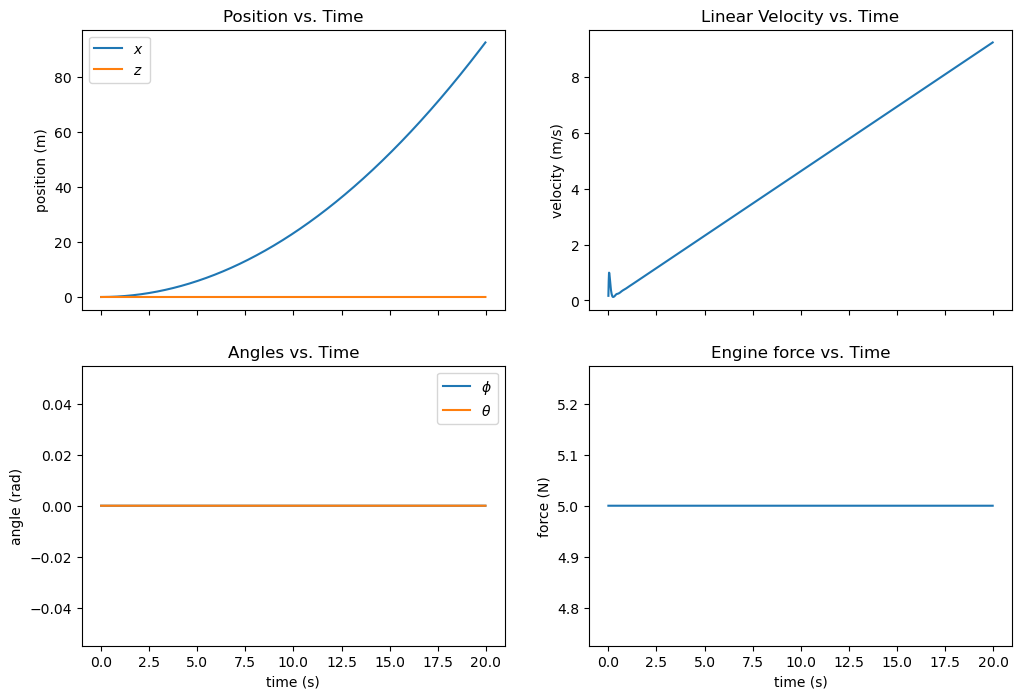

In [3]:
def plot_data(t, trajectory, trajectory_input):
    x = trajectory[:, 0]
    z = trajectory[:, 1]
    v = trajectory[:, 2]
    phi = trajectory[:, 3]
    Fe = trajectory_input[:, 0]
    theta = trajectory_input[:, 1]

    fig, axs = plt.subplots(2, 2, sharex=True, figsize = (12, 8))
    axs = axs.flatten()

    axs[0].plot(t, x, label='$x$')
    axs[0].plot(t, z, label='$z$')
    axs[0].set_title("Position vs. Time")
    axs[0].set_ylabel("position (m)")
    axs[0].legend()

    axs[1].plot(t, v)
    axs[1].set_title("Linear Velocity vs. Time")
    axs[1].set_ylabel("velocity (m/s)")

    axs[2].plot(t, phi, label=r'$\phi$')
    axs[2].plot(t, theta, label=r"$\theta$")
    axs[2].set_title("Angles vs. Time")
    axs[2].set_xlabel("time (s)")
    axs[2].set_ylabel("angle (rad)")
    axs[2].legend()

    axs[3].plot(t, Fe)
    axs[3].set_title("Engine force vs. Time")
    axs[3].set_xlabel("time (s)")
    axs[3].set_ylabel("force (N)")



t = np.linspace(0, nsamples - 1, nsamples)/hz

plot_data(t, trajectories[0], trajectories_inputs[0])

plt.show()

As expected, holding the engine force steady results in an increasing forward velocity and position, with the position increasing exponentially. What's not expected is the car being rotated slightly, likely a floating point error. I attempted to fix this by adjusting the height the car is created at in the simulation code to no avail.

Let's plot a later data set and see if there are more interesting results.

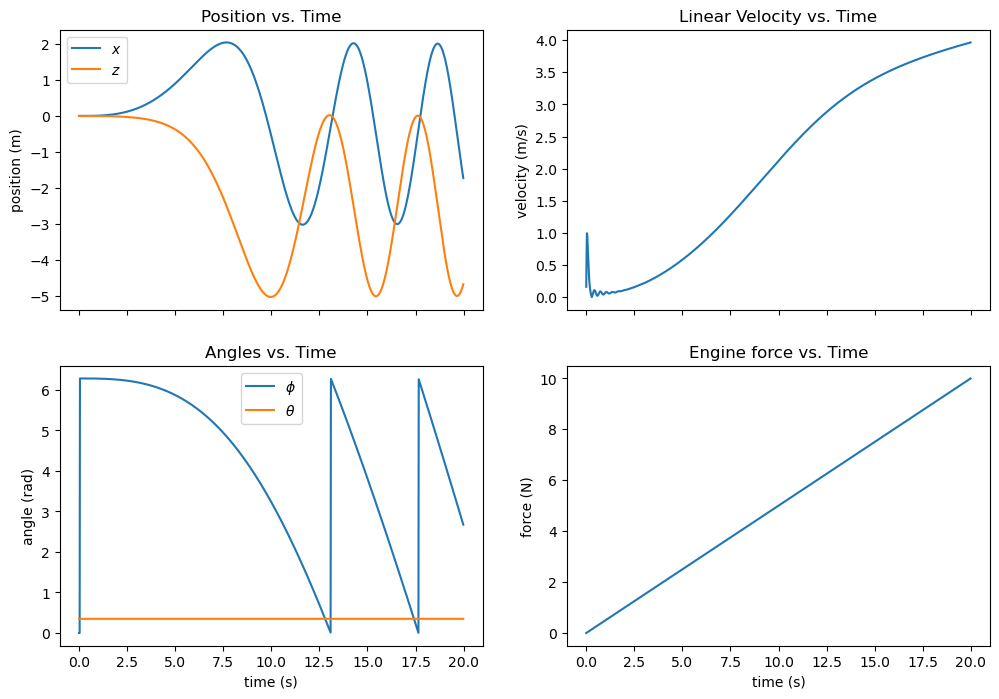

In [4]:
plot_data(t, trajectories[19], trajectories_inputs[19])

A higher engine force to start with naturally leads to faster oscillations in the position and velocity responses. Now, let's make one final plot.

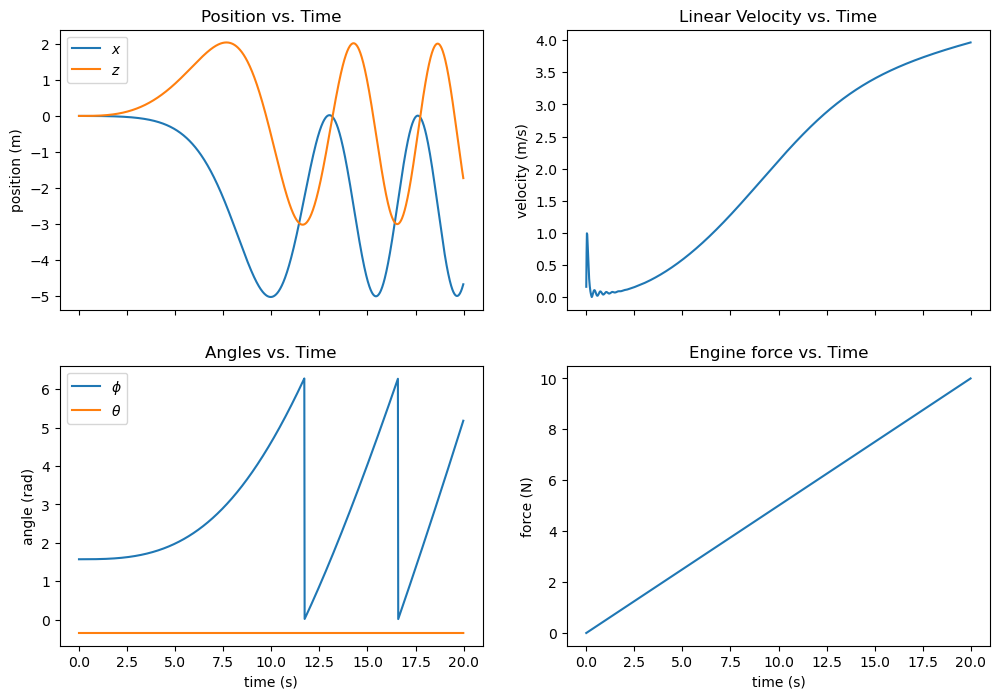

In [5]:
plot_data(t, trajectories[102], trajectories_inputs[102])

It is interesting how holding the engine force steady while changing the steering angle leads to oscillations in the state responses becoming a higher frequency.

This data will now be used to fit a SINDy model; 

Fortunately, the pySINDy Github repo provides a handy flowchart for choosing the right function library/libraries and optimizer for fitting the SINDy model to the measurement/test data.

![foo](https://raw.githubusercontent.com/dynamicslab/pysindy/master/docs/JOSS2/Fig3.png)

Since we are not solving for an implicit ODE (as far as I'm aware), the data has control inputs, is not spatially dependent and does not have significant noise, the flowchart says to use any pySINDy library. Since there are no inequality constraints in the system (as far as I'm aware), we can also use any pySINDy optimizer.

The default library is the `PolynomialLibrary`, which contains a variety of polynomial functions (to the second degree by default). PySINDy also provides a `CustomLibrary`, which will allow us to insert our own functions - we will use this to create a feature library with `sin` and `cos`, then combine with a `PolynomialLibrary`.

In [26]:
from pysindy.feature_library import *

# functions = [lambda x: np.sin(x), lambda x: np.cos(x)]
# function_names = [lambda str: f"sin({str})", lambda str: f"cos({str})"]
# lib = PolynomialLibrary() + CustomLibrary(functions, function_names)

# model = pysindy.SINDy(
#     feature_names=["x", "z", "vx", "vz", "Fe", "theta"],
#     feature_library=lib,
#     optimizer=pysindy.optimizers.STLSQ(threshold=0.001)
#     )

# model.fit(
#     x=trajectories,
#     t=t, 
#     u=trajectories_inputs,
#     multiple_trajectories=True,
#     )
# print("pySINDy indentified the following dynamics:")
# model.print()

pySINDy indentified the following dynamics:
(x)' = 1.000 vx + 0.052 vz theta + 0.006 sin(x)
(z)' = 1.000 vz + -0.052 vx theta + 0.006 sin(z)
(vx)' = -0.005 1 + -0.006 x + 0.054 vx + -0.074 z theta + 0.002 vx Fe + 0.002 vx theta + 6.194 vz theta + 0.002 theta^2 + 0.659 sin(x) + -0.014 sin(z) + 0.058 sin(vx) + -0.001 sin(vz) + 0.005 cos(theta)
(vz)' = 0.245 1 + -0.006 z + 0.054 vz + 0.074 x theta + -6.194 vx theta + 0.002 vz Fe + 0.002 vz theta + -0.117 theta^2 + 0.014 sin(x) + 0.658 sin(z) + 0.058 sin(vz) + -0.245 cos(theta)
